In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

C:\Users\adhar\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\adhar\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def show_tensor_images(image_tensor, num_images=1, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

### Generator
We built the generator class(Which has 3 values):

*   The noise vector dimension
*   The image dimension
*   The initial hidden dimension

The generator will create a neural network with 5 layers/blocks using these variables. Starting with the noise vector, the generator will use the block function to perform non-linear modifications until the tensor is mapped to the size of the picture to be outputted (the same size as the real images from MNIST).   A normalisation or activation function is not required for the last layer, but it must be scaled with a sigmoid function.

Finally, we wrote a forward pass function that takes a noise vector and uses the neural network to build an image of the output dimension.

In [3]:
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_dim=28*28, hidden_dim=128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        return self.gen(noise)
    def get_gen(self):
        return self.gen

### Noise
The noise vector z plays a crucial role in ensuring that photos created from the same class do not appear alike. Using PyTorch, we produced it at random by picking random integers from a normal distribution. We created all of the noise vectors at once because each run would process numerous photos.

In [5]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples,z_dim,device=device)

### Discriminator
The discriminator model takes a domain example (actual or produced) as input and predicts whether it is authentic or fake (generated).
The real-world example is taken from the training data set. The generator model produces the produced examples. The discriminator is a normal classification model.

We employed leaky ReLUs to avoid the "dying ReLU" problem, which occurs when a ReLU's parameters cease changing as a result of persistently negative values being fed to it, resulting in a zero gradient.

 The discriminator class holds 2 values:

*   The image dimension
*   The hidden dimension

A four-layer neural network was used to create the discriminator. It will begin with the image tensor and change it until a single number (1-dimension tensor) is returned. This output determines whether or not a picture is fake. Finally, we provided a forward pass function that takes in an image tensor to be categorised in order to use our discrimator's neural network.

In [6]:
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
         nn.Linear(input_dim, output_dim),
         nn.LeakyReLU(0.2, inplace=True)
    )

In [7]:
class Discriminator(nn.Module):
    def __init__(self, im_dim=28*28, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, image):
        return self.disc(image)
    
    def get_disc(self):
        return self.disc

 #### Parameters:
  *   criterion: The loss function
  *   n_epochs: When training, the number of times we go over the full dataset.
  *   z_dim: The dimension of the noise vector
  *   display_step: How often should the photos be displayed/visualized
  *   batch_size: The number of images per forward/backward pass
  *   lr: The learning rate
  *   device: The device type, we are using a GPU (which runs CUDA)

In [9]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 50
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001
device = 'cuda'
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

In [10]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

We wrote functions to determine the discriminator's loss and the generator's loss . This is how the discriminator and generator will be able to assess their performance and make improvements. Since the generator is needed when calculating the discriminator's loss, we need to call . detach() on the generator result to ensure that only the discriminator is updated.

In [11]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

In [12]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 1.3880853114128107, discriminator loss: 0.4192592338919636
Fake Image


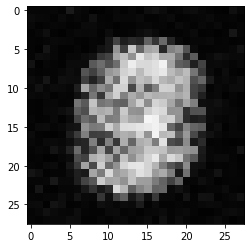

Real Image


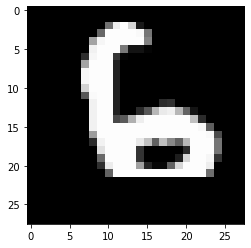

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.668965223550797, discriminator loss: 0.30028227427601806
Fake Image


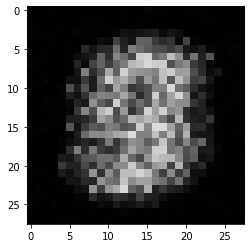

Real Image


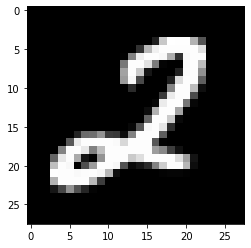

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 1.9593514552116404, discriminator loss: 0.17415947479009627
Fake Image


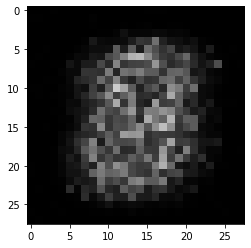

Real Image


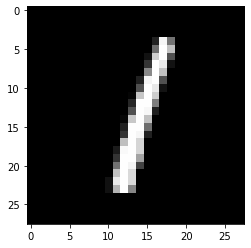

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 1.7619297189712546, discriminator loss: 0.19570803916454332
Fake Image


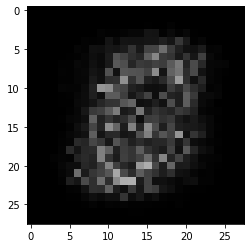

Real Image


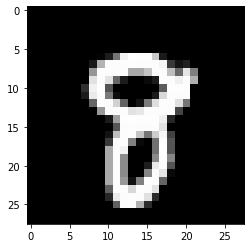

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 1.7256912560462951, discriminator loss: 0.19508411446213708
Fake Image


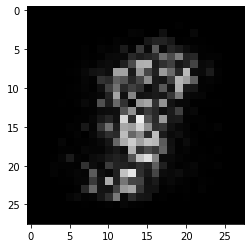

Real Image


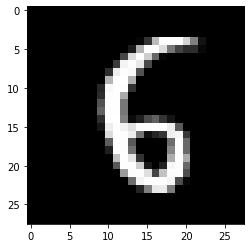

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 2.023056435108186, discriminator loss: 0.15136191086471065
Fake Image


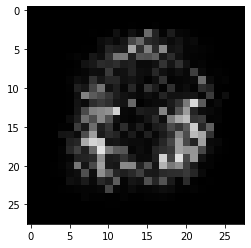

Real Image


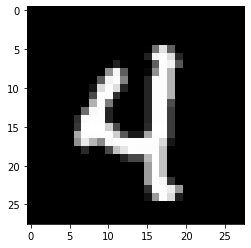

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 2.4033162136077837, discriminator loss: 0.12561426016688335
Fake Image


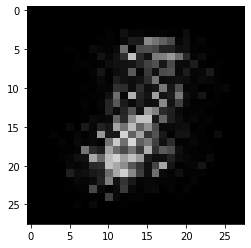

Real Image


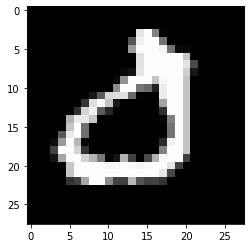

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 2.7101348915100094, discriminator loss: 0.12422805188596245
Fake Image


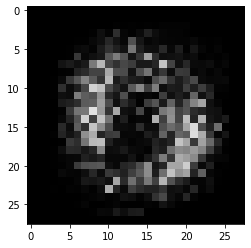

Real Image


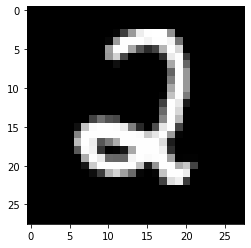

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 3.192929932117465, discriminator loss: 0.09904751966893673
Fake Image


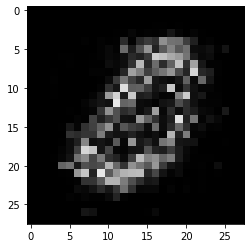

Real Image


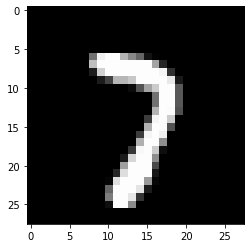

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 3.4656340217590333, discriminator loss: 0.08030975428968674
Fake Image


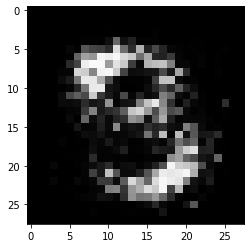

Real Image


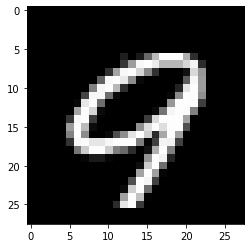

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 3.7192548289299046, discriminator loss: 0.08083053744584319
Fake Image


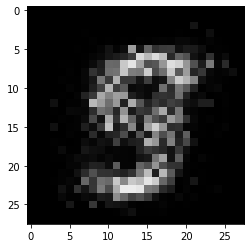

Real Image


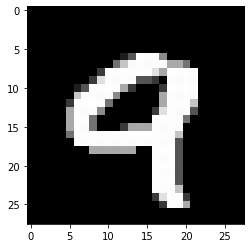

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 3.7503440923690787, discriminator loss: 0.07757014761120078
Fake Image


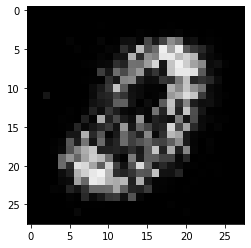

Real Image


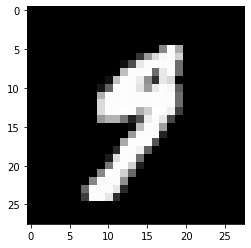

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 3.8766313982009923, discriminator loss: 0.06361387667804957
Fake Image


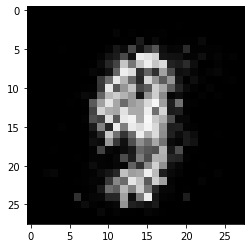

Real Image


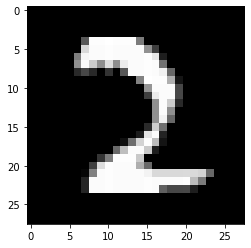

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 3.9677703237533546, discriminator loss: 0.05116609700396657
Fake Image


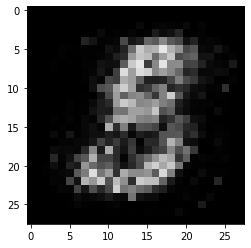

Real Image


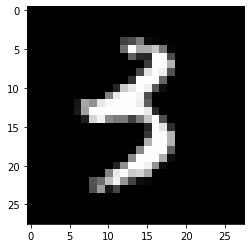

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 4.143157763004299, discriminator loss: 0.04683948381617666
Fake Image


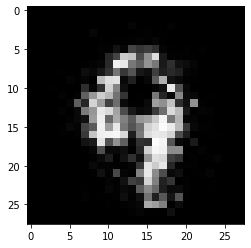

Real Image


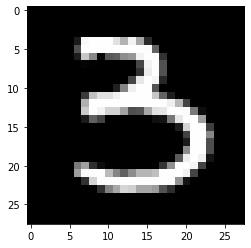

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 4.082691427707673, discriminator loss: 0.05667884077876805
Fake Image


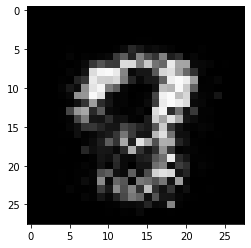

Real Image


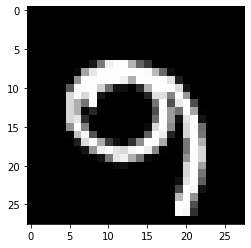

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 4.053812141895292, discriminator loss: 0.06091609946638348
Fake Image


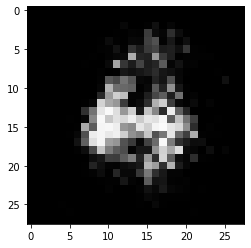

Real Image


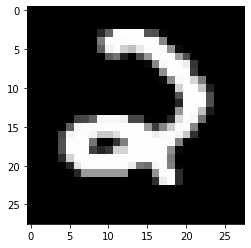

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 4.040556562423709, discriminator loss: 0.059824086315929906
Fake Image


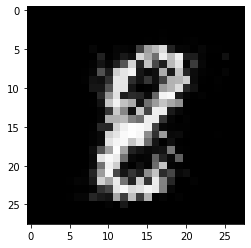

Real Image


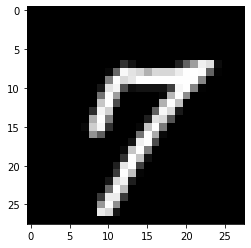

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 4.21119050693512, discriminator loss: 0.052190985698252944
Fake Image


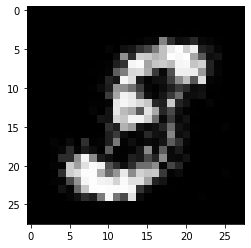

Real Image


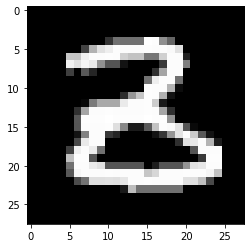

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 4.141721591949461, discriminator loss: 0.06792380571737887
Fake Image


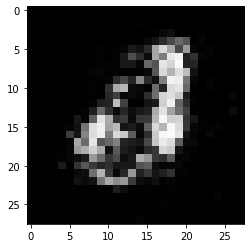

Real Image


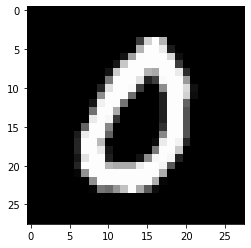

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 4.024896610736845, discriminator loss: 0.07283696600049731
Fake Image


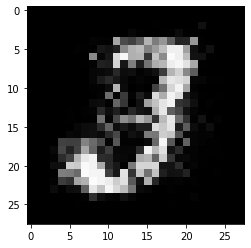

Real Image


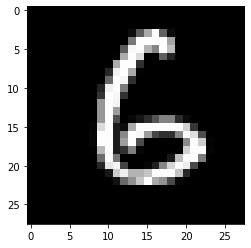

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 3.9919583463668844, discriminator loss: 0.08073554066568617
Fake Image


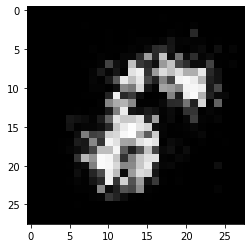

Real Image


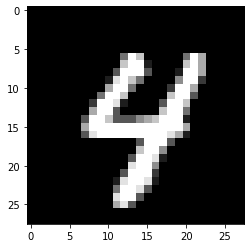

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 3.9494844121932995, discriminator loss: 0.08208559357374912
Fake Image


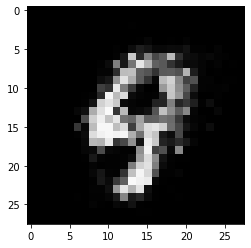

Real Image


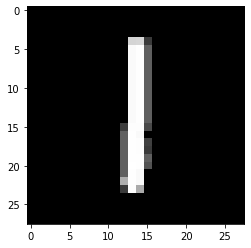

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 3.8673675289154077, discriminator loss: 0.07915483316779139
Fake Image


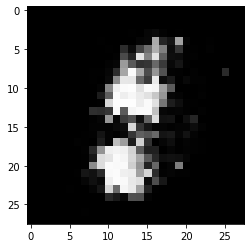

Real Image


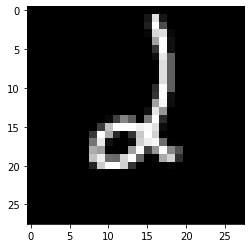

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 3.8563866128921505, discriminator loss: 0.08805636395514008
Fake Image


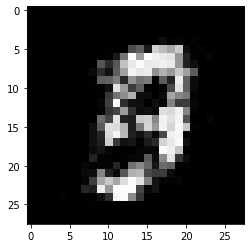

Real Image


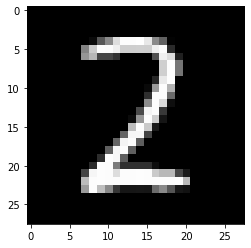

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 3.7343574314117474, discriminator loss: 0.09165935447067014
Fake Image


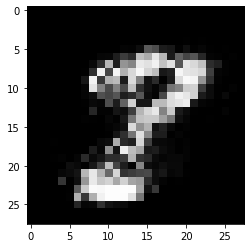

Real Image


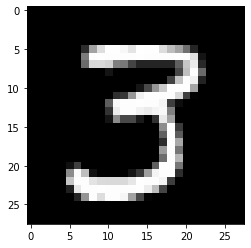

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 3.9355390057563815, discriminator loss: 0.085956331372261
Fake Image


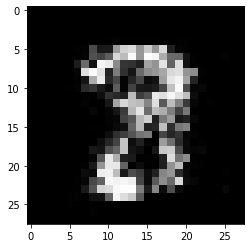

Real Image


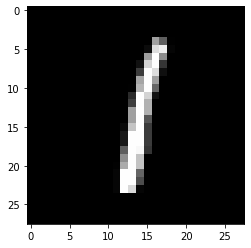

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 3.8393375968933103, discriminator loss: 0.09594281036406753
Fake Image


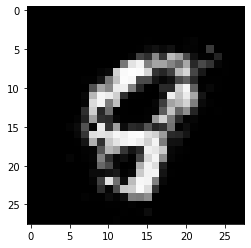

Real Image


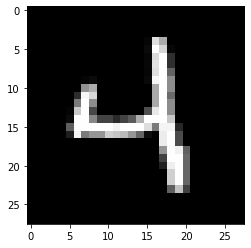

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 3.6562165613174447, discriminator loss: 0.1031302806809544
Fake Image


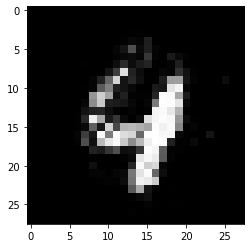

Real Image


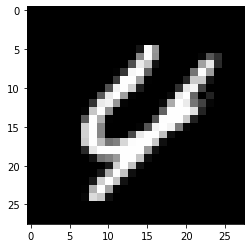

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 3.624253739833828, discriminator loss: 0.1050374386459588
Fake Image


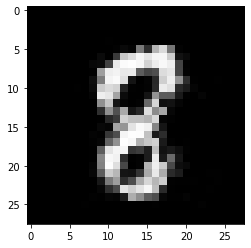

Real Image


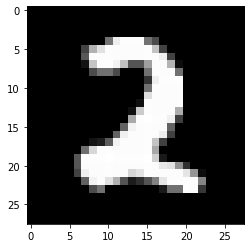

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 3.5845823349952712, discriminator loss: 0.11534130844473842
Fake Image


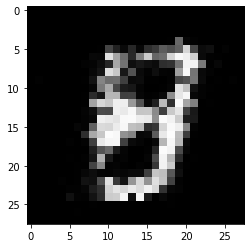

Real Image


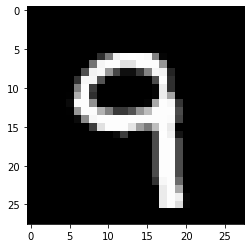

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 3.6989570655822765, discriminator loss: 0.10932588925957686
Fake Image


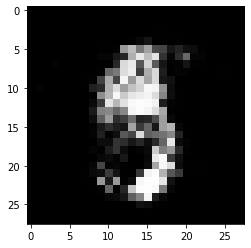

Real Image


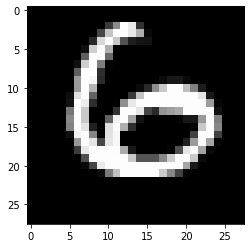

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 3.713878006458283, discriminator loss: 0.10752312801033267
Fake Image


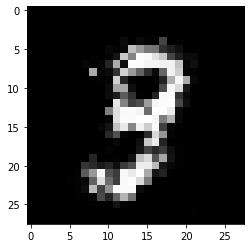

Real Image


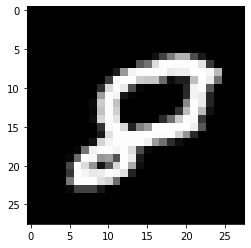

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss: 3.618638383388521, discriminator loss: 0.11638990392535914
Fake Image


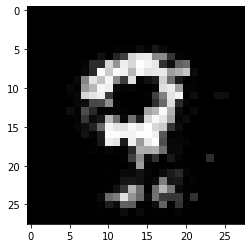

Real Image


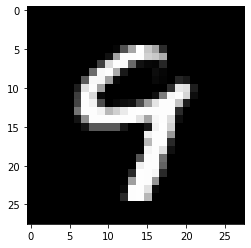

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Generator loss: 3.580103898525235, discriminator loss: 0.13083093723654748
Fake Image


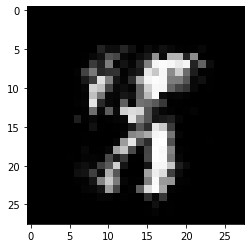

Real Image


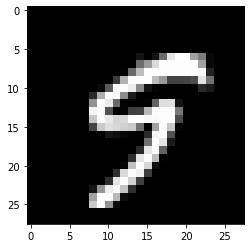

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 3.5053690299987794, discriminator loss: 0.146564766973257
Fake Image


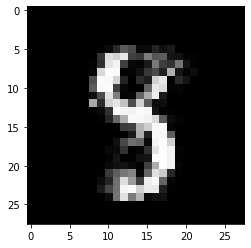

Real Image


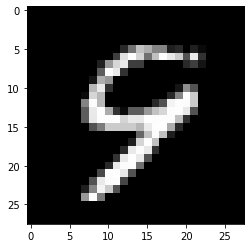

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18500: Generator loss: 3.458554943561553, discriminator loss: 0.13799888716638095
Fake Image


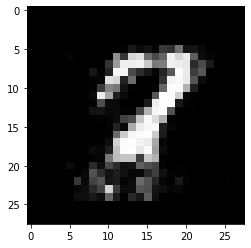

Real Image


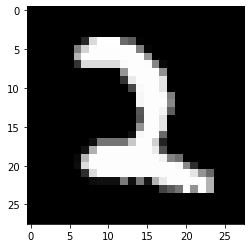

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000: Generator loss: 3.404198968410487, discriminator loss: 0.13215322288870807
Fake Image


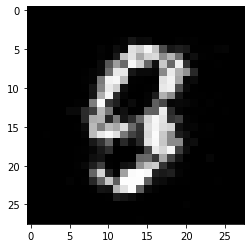

Real Image


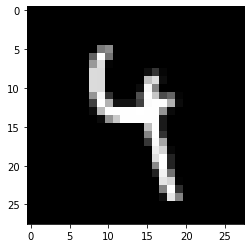

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Generator loss: 3.370829079151151, discriminator loss: 0.14521581293642535
Fake Image


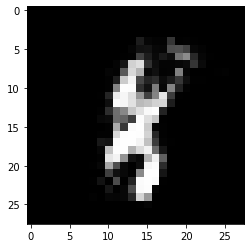

Real Image


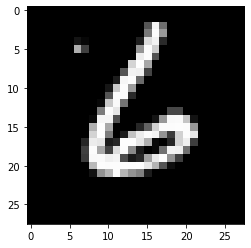

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss: 3.1819442143440257, discriminator loss: 0.1601060531437398
Fake Image


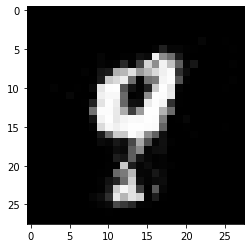

Real Image


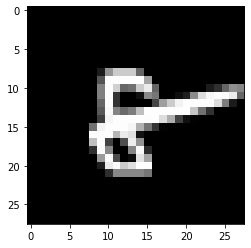

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20500: Generator loss: 3.217293590545655, discriminator loss: 0.15534986929595468
Fake Image


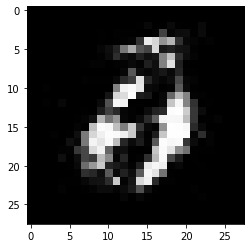

Real Image


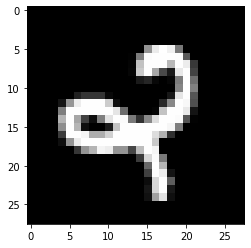

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000: Generator loss: 3.2870068683624267, discriminator loss: 0.16169988811016078
Fake Image


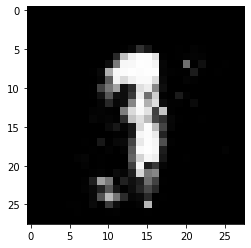

Real Image


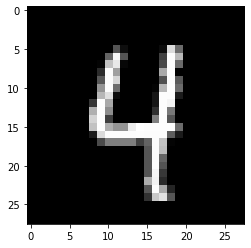

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21500: Generator loss: 3.1453673830032356, discriminator loss: 0.1489057669341564
Fake Image


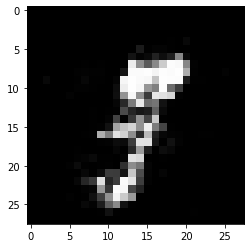

Real Image


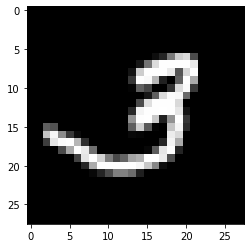

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22000: Generator loss: 3.1833674683570896, discriminator loss: 0.16090850867331027
Fake Image


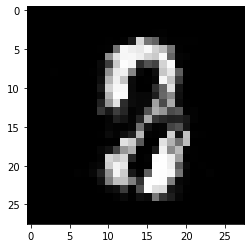

Real Image


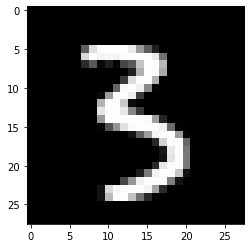

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22500: Generator loss: 3.201961245536803, discriminator loss: 0.1575966908186675
Fake Image


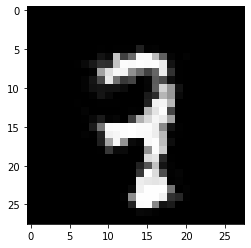

Real Image


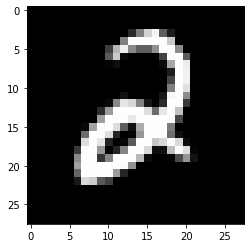

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23000: Generator loss: 3.144524403572083, discriminator loss: 0.1669583325088025
Fake Image


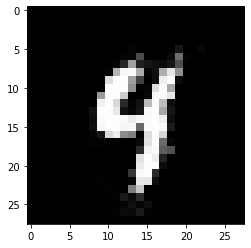

Real Image


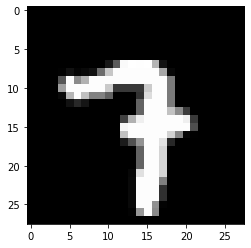

In [13]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True 
gen_loss = False
error = False
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")
        mean_discriminator_loss += disc_loss.item() / display_step
        mean_generator_loss += gen_loss.item() / display_step
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            print('Fake Image')
            show_tensor_images(fake)
            print('Real Image')
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1